In [1]:
import pandas as pd
import pickle
from collections import Counter
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn import ensemble
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")


In [2]:

###Read in data
rf=pd.read_csv('bio_txt.csv')

In [31]:
##Select predictor variable and target variable
cols=[col for col in rf if col.startswith('x_')]
X=rf[cols]
Y=rf.length_3m_dif

##Rescale to Normalize
n_X=(X-X.min())/(X.max()-X.min())
n_y=(Y-Y.min())/(Y.max()-Y.min())

##Split Data
X_train, X_test, y_train, y_test = train_test_split(n_X, n_y, test_size=0.25, random_state=42)

##Add a Bias Variable
X_train=np.hstack((X_train,np.ones((X_train.shape[0],1))))
X_test=np.hstack((X_test,np.ones((X_test.shape[0],1))))


In [32]:
## Build Model
## This is the best performing model after lots of trying and validation
X = np.nan_to_num(X_train)
y = y_train.values
regr = RandomForestRegressor(max_depth=11, random_state=42)
regr.fit(X, y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [33]:

##Get R^2 and MSE error
print('R^2 of best reduced form regressor model: ',r2_score(y_test.values, regr.predict(np.nan_to_num(X_test))))
##0.106690850879

print('MSE of best reduced form regressor model: ',mean_squared_error(y_test.values, regr.predict(np.nan_to_num(X_test))))
##0.00185661687535

R^2 of best reduced form regressor model:  0.0180105996194
MSE of best reduced form regressor model:  0.00204978751289


In [20]:

# Print Top 10 Feature Importance
d=(sorted(zip(map(lambda x: round(x, 10), regr.feature_importances_), list(rf[cols].columns)+['intercept']), 
             reverse=True))
print('feature_importances:')
importances=[]
features=[]
for (i,j) in d[:10]:
    importances.append(i)
    features.append(j)
    print(j,i)


feature_importances:
x_instate_ba_dm 0.069308686
x_b10s_dm 0.0479696634
x_mainline_dm 0.0467233361
x_sdem_dm 0.0433034768
x_pssenate_dm 0.0429862463
x_ageon40orless_dm 0.039850547
x_agecommi_dm 0.0285297318
x_unity_dm 0.0283212245
x_pgovt_dm 0.0237391068
x_b20s_dm 0.0235830425


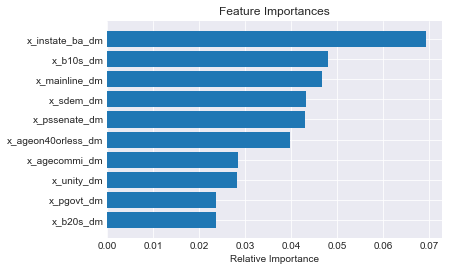

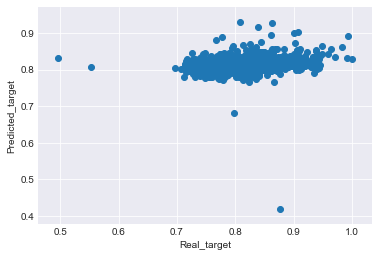

In [22]:
## Plot feature importances
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(d[:10])), importances[::-1], align='center')
plt.yticks(range(len(d[:10])), features[::-1])
plt.xlabel('Relative Importance')
plt.show()

## Plot Real vs Predicted scatter plot
plt.scatter(y_test.values,regr.predict(np.nan_to_num(X_test)))
plt.xlabel('Real_target')
plt.ylabel('Predicted_target')
plt.show()

In [25]:

########this is when turning this into classification problem by categorize sentencing length changes

##Catergorize feature
def cat(v):
    if v>(-0.5) and v<0.5:
        return 0
    elif v>=0.5:
        return 1
    else:
        return -1
    
X=rf[cols]

Y=rf.length_3m_dif

##Catergorize feature
Y=Y.apply(cat)
##Rescale to Normalize
n_X=(X-X.min())/(X.max()-X.min())

##Train Test Split
X_train, X_test, y_train, y_test = train_test_split(n_X, Y, test_size=0.25, random_state=42)   


X = np.nan_to_num(X_train)
y = y_train.values
##Build Classifier
classifier =ensemble.GradientBoostingClassifier(max_depth=5)
classifier.fit(X,y)

##Get predicted category
y_pred = classifier.predict(np.nan_to_num(X_test))
reversefactor = dict(zip([-1,0,1],['Decrease','NotChanged','Increase']))
y_testing = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)

In [28]:

# Making the Confusion Matrix
print(pd.crosstab(y_testing, y_pred, rownames=['Actual'], colnames=['Predicted']))
print('F1 Score is: ',f1_score(y_testing, y_pred, labels=None, average='micro', sample_weight=None))


Predicted   Decrease  Increase  NotChanged
Actual                                    
Decrease         270       270          55
Increase         186       511          86
NotChanged       114       217         138
F1 Score is:  0.497563616676
